In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from torch import nn
import torch
from argparse import Namespace
from models.FITS import FITS

%config InlineBackend.figure_format = 'retina'

In [133]:
df = pd.read_csv("../data/GD.csv", index_col=0)
num_samples = len(df)

base_freq = 120
seq_len = 720
pred_len = 720

cut_off_harmonic = 5


args = Namespace(
    dominance_freq=120,
    seq_len=seq_len,
    pred_len=pred_len,
    channels=1,
    individual=False,
    debug=True,
)

model = FITS(args)

model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

print(model)

FITS(
  (frequency_upsampler): Linear(in_features=120, out_features=240, bias=True)
)


In [130]:
y = df.values.T[0]
y = (y - y.mean()) / y.std()
y.shape

(15721,)

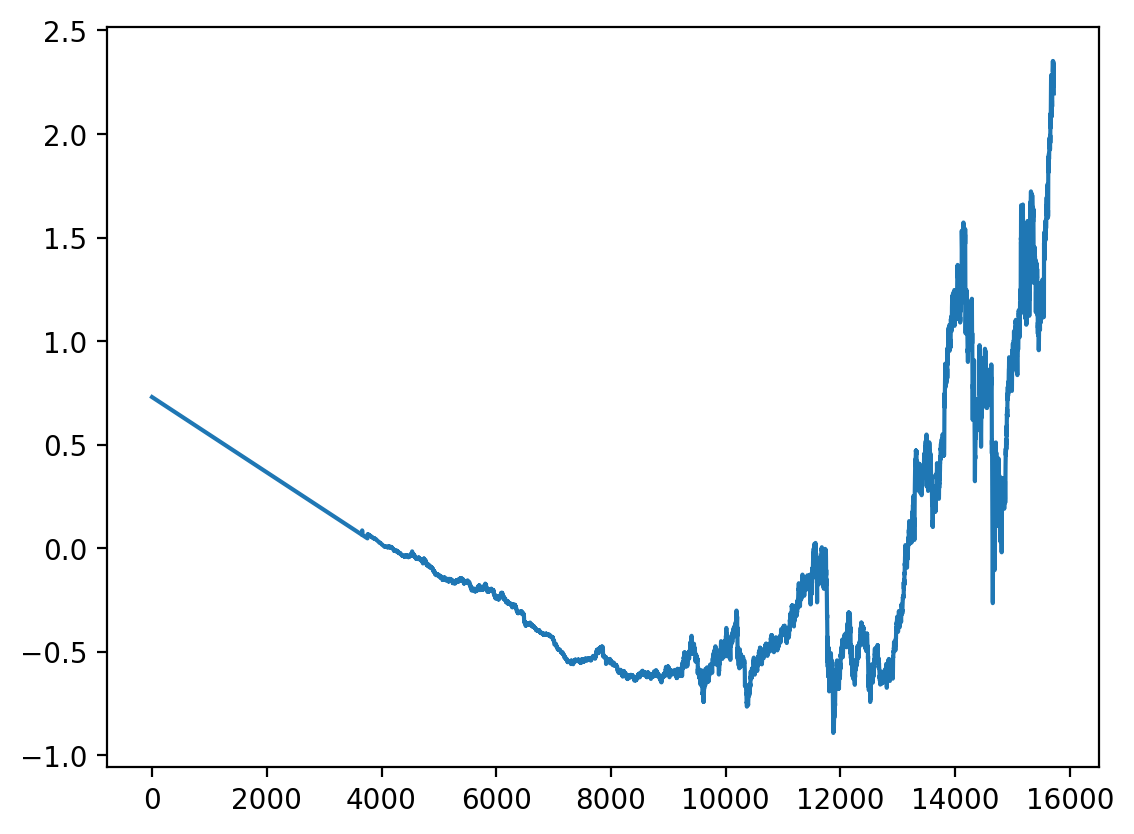

In [119]:
from scipy import stats

x = np.arange(len(y))
slope, intercept, _, _, _ = stats.linregress(x, y)
y_trend = slope * x + intercept
y_detrended = y - y_trend

plt.plot(y_detrended)

In [120]:
y = y_detrended

In [121]:
def train(model, model_optim, n_channels, y):
    for epoch in range(1000):  # train 1000 epochs
        order = np.random.permutation(
            int(num_samples * 0.8)
        )  # shuffle the training sample
        train_loss = []
        for batch in range(25):  # split each epoch into 25 batches
            batch_start = order[
                batch * 80 : (batch + 1) * 80
            ]  # each batch has 80 samples
            batch = []

            for i in batch_start:
                batch.append(y[i : i + seq_len + pred_len])

            batch_xy = np.array(batch).reshape(
                80, seq_len + pred_len, n_channels
            )  # 80 batch_size, 360 time steps, n features

            batch_xy = torch.from_numpy(batch_xy).float()

            batch_x = batch_xy[:, :seq_len, :]
            batch_y = batch_xy[:, seq_len:, :]

            model_optim.zero_grad()

            output = model(batch_x)

            # output=output[:,-120:,:]

            loss = criterion(output, batch_xy)

            train_loss.append(loss.item())

            loss.backward()

            model_optim.step()

        print(f"\repoch: {epoch} \t loss: {np.mean(train_loss):4f}", end="", flush=True)
    return model, np.mean(train_loss)

In [122]:
model, train_loss = train(model, model_optim, 1, y)

epoch: 999 	 loss: 0.017296

In [123]:
batch_xy = torch.from_numpy(
    y[-(seq_len + pred_len) :].reshape(1, seq_len + pred_len, 1)
).float()
batch_x = batch_xy[:, :seq_len, :]

with torch.no_grad():
    output = model(batch_x)
    loss = criterion(output, batch_xy)

output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

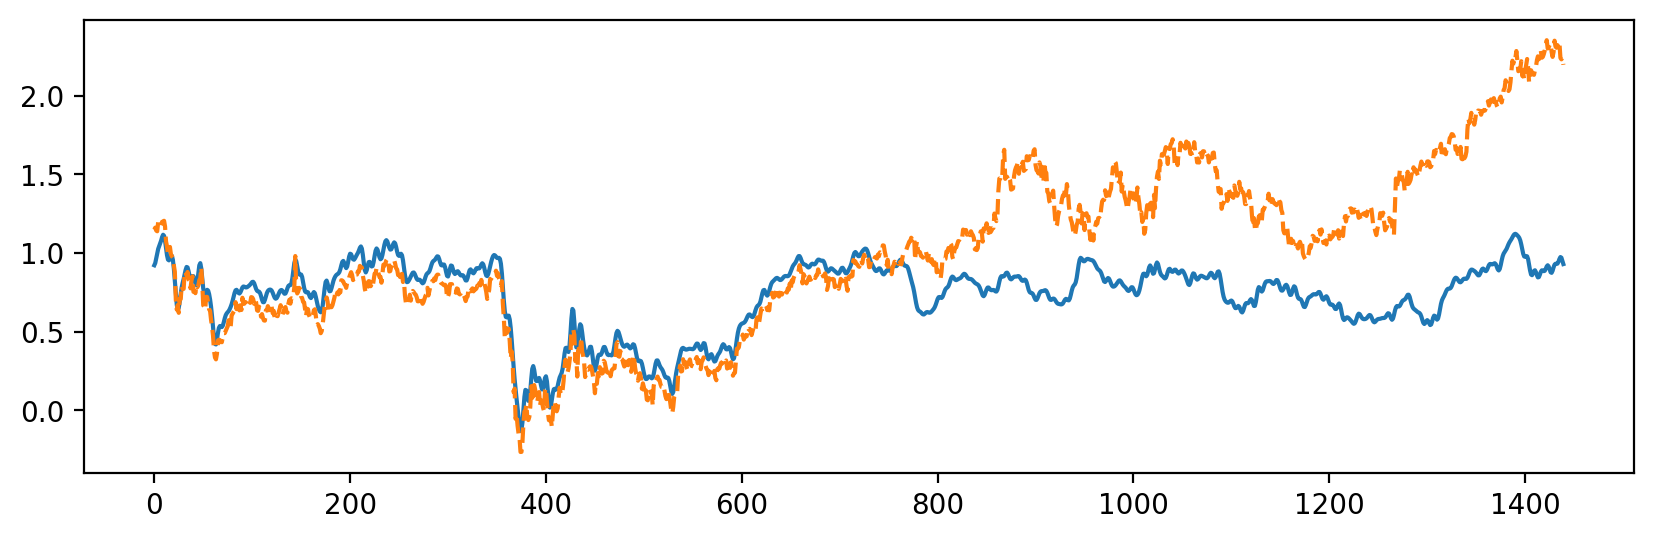

In [124]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth

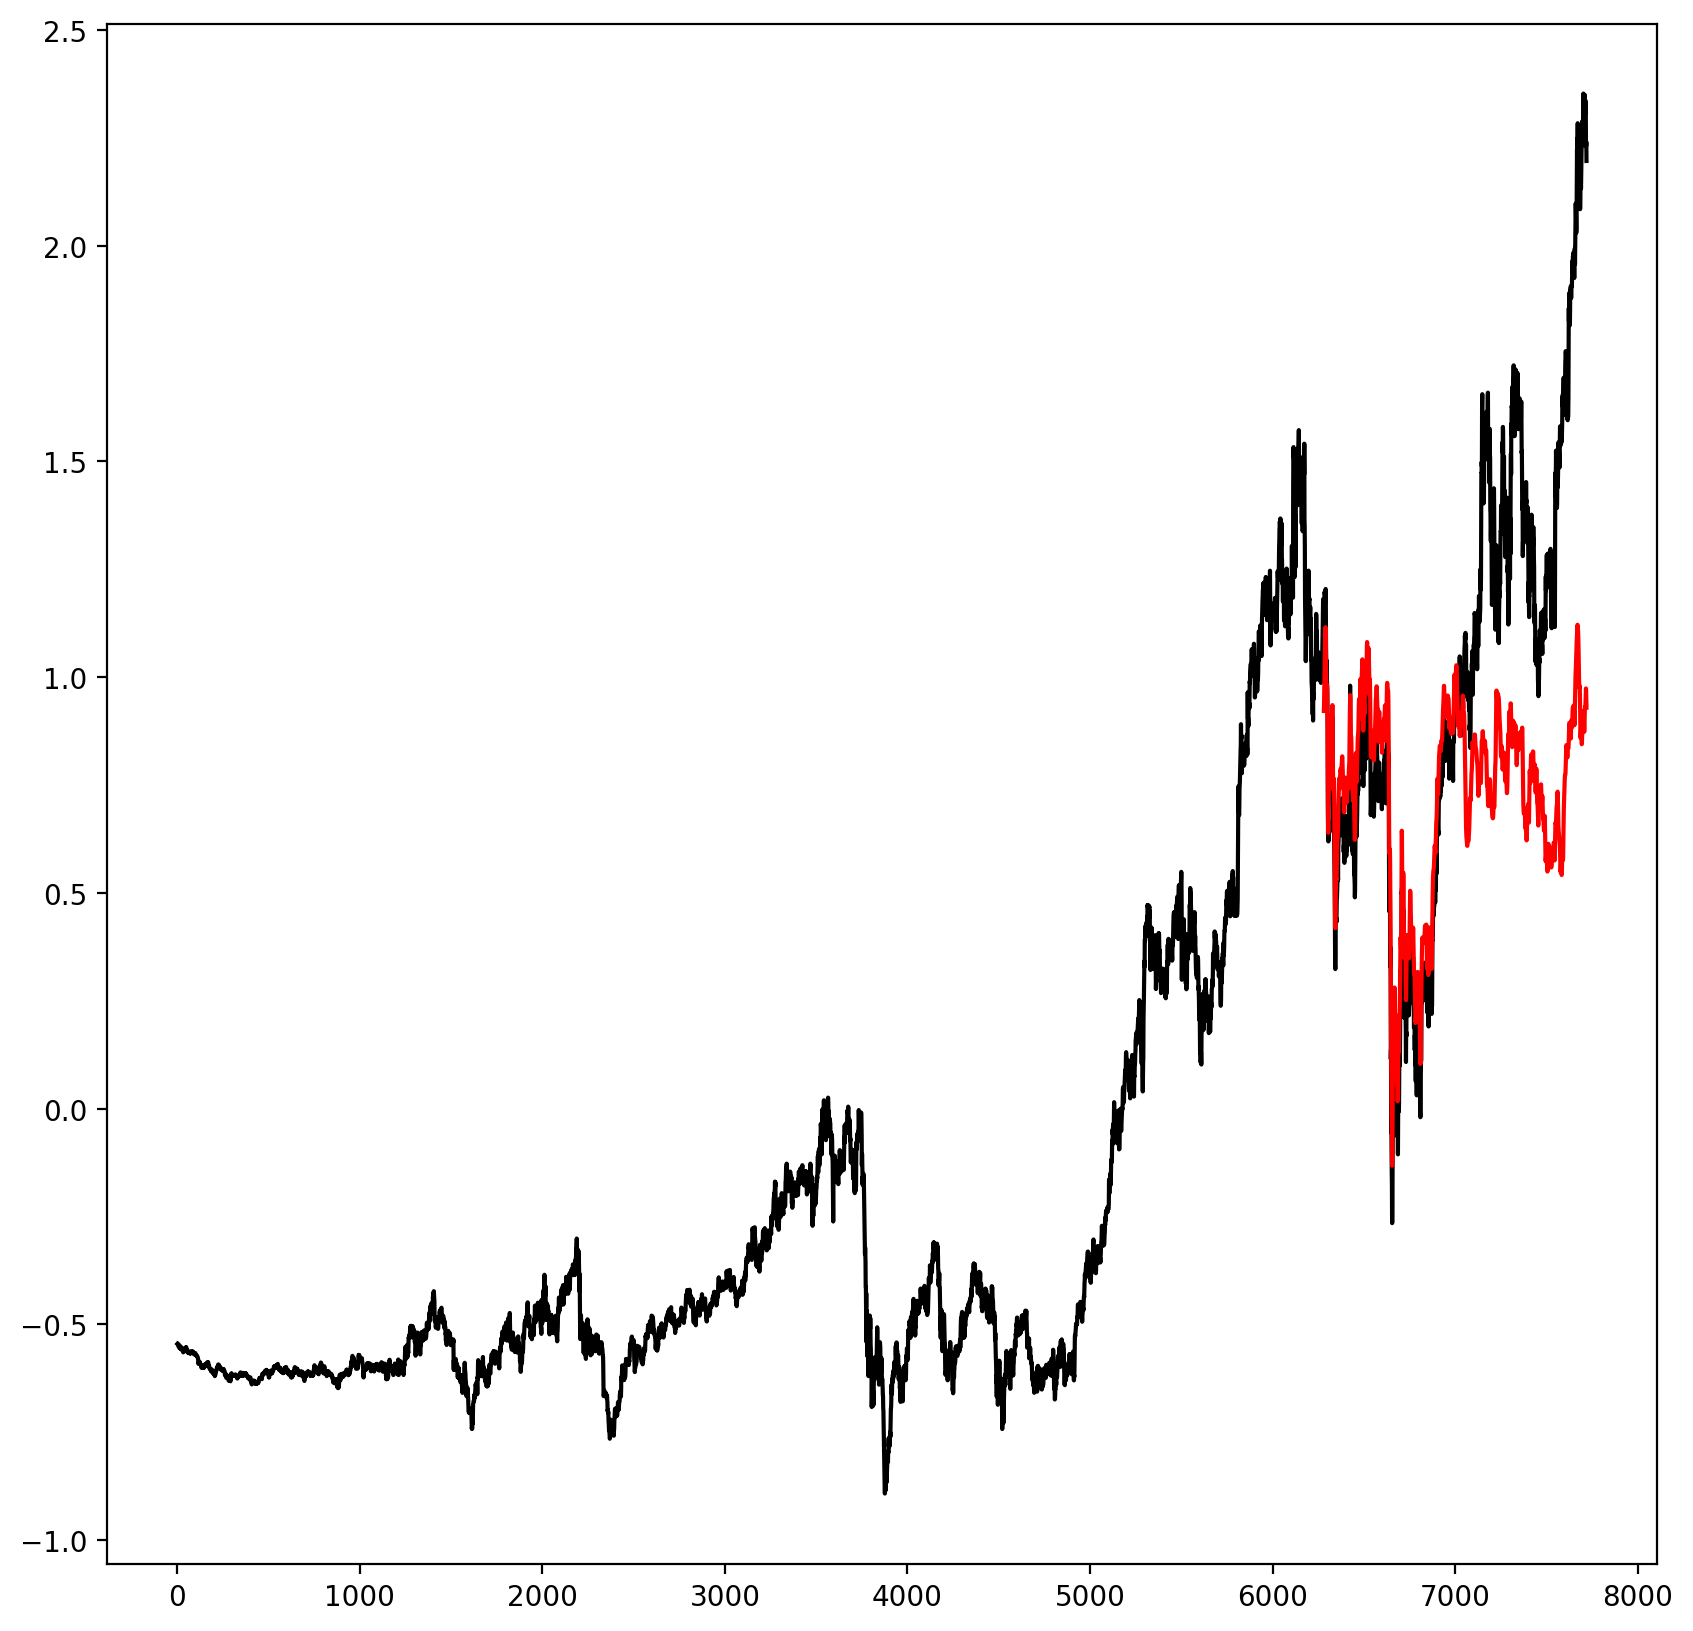

In [125]:
# overlay output
plt.figure(figsize=(10, 10))
n = 8000
plt.plot(y[n:], color="black")
plt.plot(np.arange(len(y[n:]))[-(pred_len + seq_len) :], output[0, :, 0], color="red")